### Use case: interpolate, compute and plot mean from FDB stream

Demonstrates the following workflow with the available earthkit components:
- read multiple T2m fields from an FDB stream 
- interpolate them onto another (lat-lon) grid and area
- compute the mean as an ndarray
- generate a plot for the mean

All of it is done by using an iteration and keeping only one GRIB field in memory at a time. No data is written to disk.

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import mir
import pyfdb
import emohawk

We read the data from FDB. What we get is a stream. **Note**: FDB_HOME must be correctly set!

In [2]:
# date must be adjusted since FDB only stores recent dates
request = {
    'class': 'od',
    'expver': '0001',
    'stream': 'oper',
    'date': '20230219',
    'time': '0000',
    'domain': 'g',
    'type': 'fc',
    'levtype': 'sfc',
    'step': list(range(0,48,3)),
    'param': 167
}

# Must be set correctly
%env FDB_HOME=/home/fdbprod

fdb = pyfdb.FDB()
stream = fdb.retrieve(request)

env: FDB_HOME=/home/fdbprod


We create an emohawk stream iterator. Nothing is read at the moment:

In [3]:
fs = emohawk.load_from("stream", stream)

We perform the interpolation and start the computation:

In [4]:
# define the interpolation job
job = mir.Job(grid='0.2/0.2', area='70/-30/20/70')

res = None
num = 0

# iterating through the GRIB fields from the stream
for f in fs:
    # interpolate - 
    # the input is a GRIB message in memory
    # the output is a GRIB message in memory stored in a BytesIO object 
    data = f.message()
    data_in = mir.GribMemoryInput(data)
    data_out = io.BytesIO()
    job.execute(data_in, data_out)
    
    # load the resulting GRIB message into emohawk
    g = emohawk.load_from("memory", data_out.getvalue())[0]
    
    if res is None:
        # start accumulation
        res = g.to_numpy()
        
        # get metadata for plotting
        lat, lon = g.metadata(["latitudes", "longitudes"])
    else:
        # accumulation
        res += g.to_numpy()
        
    num += 1

Compute the mean.

In [5]:
res /= num  
print(f"num={num}")
print(res)

num=16
[249.87856579 250.2372694  250.86056042 ... 298.64986706 298.58278942
 298.6256361 ]


Result is scaled for plotting.

In [6]:
res -= 273.16

Generate plot.

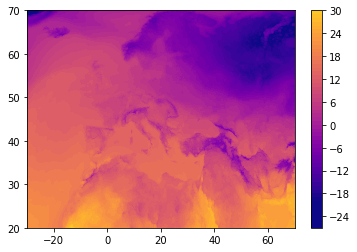

In [7]:
fig, ax = plt.subplots()
tcf = ax.tricontourf(lon, lat, res, vmin=-20, vmax=36, levels=56, cmap="plasma")
fig.colorbar(tcf)
plt.show()